#Set up for downloading kaggle dataset

[Checkout this article for downloading the dataset](https://https://www.kaggle.com/discussions/general/74235)

##Add your  Kaggle key and kaggle username in the secrets
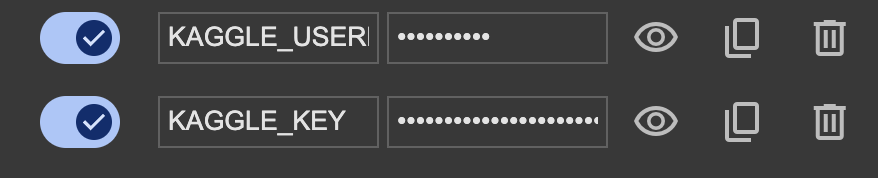

In [1]:
from google.colab import userdata
import os

os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')


#Downloading Dataset

In [2]:
import zipfile

In [3]:
!kaggle datasets download -d phucthaiv02/butterfly-image-classification
!kaggle datasets download -d datatattle/covid-19-nlp-text-classification
!kaggle datasets download -d warcoder/cats-vs-dogs-vs-birds-audio-classification

Dataset URL: https://www.kaggle.com/datasets/phucthaiv02/butterfly-image-classification
License(s): CC0-1.0
 97% 219M/226M [00:02<00:00, 72.0MB/s]
100% 226M/226M [00:02<00:00, 83.2MB/s]
Dataset URL: https://www.kaggle.com/datasets/datatattle/covid-19-nlp-text-classification
License(s): copyright-authors
  0% 0.00/4.38M [00:00<?, ?B/s]
100% 4.38M/4.38M [00:00<00:00, 73.3MB/s]
Dataset URL: https://www.kaggle.com/datasets/warcoder/cats-vs-dogs-vs-birds-audio-classification
License(s): Attribution 4.0 International (CC BY 4.0)
 76% 10.0M/13.2M [00:00<00:00, 49.1MB/s]
100% 13.2M/13.2M [00:00<00:00, 52.8MB/s]


In [4]:
zip_ref = zipfile.ZipFile('butterfly-image-classification.zip', 'r')
os.makedirs("/content/Image_classification-butterfly_image_dataset",exist_ok=True)
zip_ref.extractall('/content/Image_classification-butterfly_image_dataset')
zip_ref.close()

In [5]:
zip_ref = zipfile.ZipFile('covid-19-nlp-text-classification.zip', 'r')
os.makedirs("/content/Text_classification-Coronavirus_tweets_NLP",exist_ok=True)
zip_ref.extractall('/content/Text_classification-Coronavirus_tweets_NLP')
zip_ref.close()

In [6]:
zip_ref = zipfile.ZipFile('cats-vs-dogs-vs-birds-audio-classification.zip', 'r')
os.makedirs("/content/Audio_classification-cats-vs-dogs-vs-birds",exist_ok=True)
zip_ref.extractall('/content/Audio_classification-cats-vs-dogs-vs-birds')
zip_ref.close()

#Custom Dataset classes

##1. For Image Classification

In [7]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader


import numpy as np
import os
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt

In [8]:
class ImageDataset(Dataset):
    def __init__(self, data_dir, annotations_file, transforms=None):
        """
        Dataset for Image Data.

        Args:
            data_dir (str): Directory containing the image files.
            annotations_file (str): Path to the annotations file for supervised tasks.
            transforms (callable, optional): Optional transformations to be applied on images.
        """
        self.data_dir = data_dir
        self.annotations_file = annotations_file
        self.transforms = transforms

        self.annotation_classes={}
        self.annotations = pd.read_csv(annotations_file,)
        # optional as we generally require the labels in the int datatype
        self.annotation_classes={k:i for i,k in enumerate(self.annotations['label'].unique())}


    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):

        img_path=os.path.join(self.data_dir,self.annotations.iloc[idx]['filename'],)
        img = Image.open(img_path)
        if self.transforms:
            img = self.transforms(img)

        label_str=self.annotations.iloc[idx]['label']
        label = self.annotation_classes[label_str]
        return img, label

    def convert_itoc(self,x):
      # optional convert int values in classes
      itoc={i:k for k,i in self.annotation_classes.items()}
      x=x.int().numpy()
      return itoc[x[0]] if len(x)==1 else [itoc[xi] for xi in x]

In [9]:
image_dataset = ImageDataset(
        data_dir='/content/Image_classification-butterfly_image_dataset/train',
        annotations_file='/content/Image_classification-butterfly_image_dataset/Training_set.csv',
        transforms=transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ])
    )

train_dataloader = DataLoader(image_dataset, batch_size=1, shuffle=True)

In [10]:
train_features, train_labels = next(iter(train_dataloader))

(-0.5, 223.5, 223.5, -0.5)

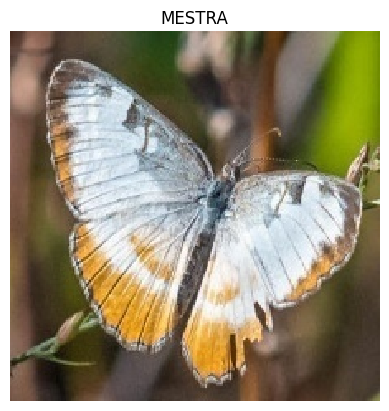

In [11]:
npimg = train_features.squeeze(0).numpy()
plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation='nearest',)
plt.title(image_dataset.convert_itoc(train_labels))
plt.axis("off")

##2. For Text Classification

In [12]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
from sklearn.model_selection import train_test_split
import spacy
import pandas as pd
from tqdm.notebook import tqdm


In [13]:
nlp = spacy.load("en_core_web_sm")

In [14]:
class TextDataset(Dataset):
    def __init__(self, csv_file, max_length, text_col, label_col,encoding="utf-8",n_records=1):
      """
        Initializes the TextDataset instance.

        Args:
            csv_file (str): Path to the CSV file containing the dataset.
            max_length (int): Maximum sequence length for tokenization.
            text_col (str): Name of the column containing text data.
            label_col (str): Name of the column containing labels.
            encoding (str, optional): File encoding. Defaults to "utf-8".
            n_records (float, optional): Fraction of the dataset to include. Defaults to 1.
      """
      self.data = pd.read_csv(csv_file,encoding=encoding)
      self.len=int(len(self.data)*n_records)
      self.data=self.data.iloc[0:self.len]
      self.label_encoder={k:i for i,k in enumerate(list(set(self.data[label_col])))}
      self.data['new_labels']=[self.label_encoder[label] for label in self.data[label_col]]
      self.max_length = max_length
      self.text_col = text_col
      self.label_col = label_col
      self.vocab,self.vocab_decoder = self.build_vocab()

    def __len__(self):
      return len(self.data)

    def __getitem__(self, idx):
      text = self.data.iloc[idx][self.text_col]
      label = self.data.iloc[idx]['new_labels']

      # Tokenize the text using spaCy
      tokens = [token.text for token in nlp(text)]

      # Convert tokens to indices using the vocab
      # we are sending the constant sequence of tokens in the NN
      # so that we are either padding it if the sequnce is small or truncate if the sequence is large
      token_indices = [self.vocab.get(token, self.vocab["<UNK>"]) for token in tokens[:self.max_length]]
      padding_length = self.max_length - len(token_indices)

      # Pad or truncate to the required max length
      token_indices += [self.vocab["<PAD>"]] * padding_length

      # Convert to tensors
      input_ids = torch.tensor(token_indices, dtype=torch.long)

      return input_ids, torch.tensor(label, dtype=torch.long)

    def build_vocab(self,max_vocab_size=10000):

      texts=self.data[self.text_col]

      word_freq = {}
      for text in tqdm(texts):
          tokens = [token.text for token in nlp(text)]
          for token in tokens:
              word_freq[token] = word_freq.get(token, 0) + 1

      # Sort by frequency and take the most common words
      sorted_vocab = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)[:max_vocab_size]

      # Create vocab dict
      vocab = {word: idx for idx, (word, _) in enumerate(sorted_vocab, start=2)}
      vocab["<PAD>"] = 0  # Padding token
      vocab["<UNK>"] = 1  # Unknown token
      vocab_decoder={idx:word for word,idx in vocab.items()}
      return vocab,vocab_decoder

    def decode_labels(self,x):
      label_decoder={i:k for k,i in self.label_encoder.items()}
      return label_decoder[int(x[0])] if len(x)==1 else [label_decoder(int(xi)) for xi in x.squeeze(0)]

    def decode_tokens(self,x):
      print(x.squeeze(0).shape)
      return [self.vocab_decoder[int(xi)] for xi in x.squeeze(0)]




In [15]:
dataset = TextDataset(
    '/content/Text_classification-Coronavirus_tweets_NLP/Corona_NLP_train.csv',
    50,
    'OriginalTweet',
    'Sentiment',
    encoding='latin1',
    n_records=0.001 # increase number of records
    )

  0%|          | 0/41 [00:00<?, ?it/s]

In [16]:
train_loader = DataLoader(dataset, batch_size=1, shuffle=True)

In [17]:
input_ids, labels =  next(iter(train_loader))

In [18]:
dataset.decode_tokens(input_ids),dataset.decode_labels(labels)

torch.Size([50])


(['Was',
  'at',
  'the',
  'supermarket',
  'today',
  '.',
  'Did',
  "n't",
  'buy',
  'toilet',
  'paper',
  '.',
  '#',
  'Rebel',
  '\r\r\n\r\r\n',
  '#',
  'toiletpapercrisis',
  '#',
  'covid_19',
  'https://t.co/eVXkQLIdAZ',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>',
  '<PAD>'],
 'Neutral')

##3. Sound Classification

In [19]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import os
import pandas as pd
import numpy as np
from torchaudio import load as load_audio

In [20]:
import librosa


In [23]:
class SoundDataset(Dataset):
    def __init__(self, data_dir, annotations_file=None, sample_rate=None, filepath_col="files", label_col="labels"):
        """
        Dataset for Sound Data.

        Args:
            data_dir (str): Directory containing the audio files.
            annotations_file (str, optional): Path to the annotations file for supervised tasks.
            sample_rate (int, optional): Desired sample rate for audio data.
            filepath_col (str, optional): Column name for file paths in the annotations file. Defaults to "files".
            label_col (str, optional): Column name for labels in the annotations file. Defaults to "labels".
        """
        # Initialize directory paths and configuration parameters
        self.data_dir = data_dir
        self.annotations_file = annotations_file
        self.sample_rate = sample_rate
        self.filepath_col = filepath_col
        self.label_col = label_col

        # Collect all audio file paths in the directory with valid extensions
        self.file_paths = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith(('wav', 'mp3'))]

        # Load annotations if provided, otherwise create a default annotations DataFrame
        if annotations_file:
            self.annotations = pd.read_csv(annotations_file)
        else:
            arr = []
            labels=os.listdir(self.data_dir)
            for label in labels:
                files = os.listdir(os.path.join(self.data_dir, label))
                for file in files:
                    arr.append((file, label))
            self.annotations = pd.DataFrame(arr, columns=["files", "labels"])

        # Encode labels into integers for model compatibility
        self.label_encoder = {k: i for i, k in enumerate(list(set(self.annotations[label_col])))}

    def __len__(self):
        """
        Returns the total number of annotated samples in the dataset.

        Returns:
            int: Number of annotated samples.
        """
        return len(self.annotations)

    def __getitem__(self, idx):
        """
        Retrieves a single audio sample and its corresponding label by index.

        Args:
            idx (int): Index of the sample to retrieve.

        Returns:
            tuple: A tuple containing the audio tensor and the encoded label.
        """
        # Construct the full path to the audio file
        audio_path = os.path.join(self.data_dir, self.annotations.iloc[idx][self.label_col], self.annotations.iloc[idx][self.filepath_col])

        # Load the audio file and its sampling rate
        audio, sr = load_audio(audio_path)

        # Resample audio if a target sample rate is specified and differs from the original
        if self.sample_rate and self.sample_rate != sr:
            audio = librosa.resample(audio.numpy().squeeze(), sr, self.sample_rate)
            audio = torch.tensor(audio)

        # Retrieve and encode the label for the sample
        label = self.annotations.iloc[idx][self.label_col]
        return audio, self.label_encoder[label]

    def decode_labels(self, x):
        """
        Converts encoded labels back to their original string representations.

        Args:
            x (torch.Tensor): Tensor of encoded label(s).

        Returns:
            str or list: Decoded label(s) as a string or a list of strings.
        """
        # Create a decoder mapping from integers to label strings
        label_decoder = {i: k for k, i in self.label_encoder.items()}

        # Decode a single label or a batch of labels
        return label_decoder[int(x[0])] if len(x) == 1 else [label_decoder[int(xi)] for xi in x.squeeze(0)]


In [24]:
sound_dataset = SoundDataset(
        data_dir='/content/Audio_classification-cats-vs-dogs-vs-birds/Animals',
        sample_rate=16000
    )

In [25]:
train_loader = DataLoader(sound_dataset, batch_size=1, shuffle=True)

In [26]:
a,l=next(iter(train_loader))

In [27]:
a,sound_dataset.decode_labels(l)

(tensor([[[0.0020, 0.0021, 0.0022,  ..., 0.0030, 0.0029, 0.0028]]]), 'dog')

## 4. For Text: Named Entity Recognition

In [30]:
import torch
from torch.utils.data import Dataset
from transformers import AutoTokenizer

In [31]:
class TextDataset(Dataset):
    def __init__(self, texts, annotations, tokenizer, max_length=512):
        """
        Args:
            texts (list of str): List of raw text samples.
            annotations (list of dict): List of annotations for each text, e.g., {'entities': [(start, end, label)]}.
            tokenizer: Tokenizer to convert text into tokens.
            max_length (int): Maximum sequence length for padding/truncation.
        """
        self.texts = texts
        self.annotations = annotations
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        annotation = self.annotations[idx]

        # Tokenize the text
        tokens = self.tokenizer(
            text,
            max_length=self.max_length,
            truncation=True,
            padding="max_length",
            return_offsets_mapping=True
        )
        input_ids = tokens['input_ids']
        attention_mask = tokens['attention_mask']
        offsets = tokens['offset_mapping']

        # Create labels for tokens
        labels = [0] * len(input_ids)  # Default label: 0 (non-entity)
        for start, end, label in annotation['entities']:
            for i, (token_start, token_end) in enumerate(offsets):
                if token_start >= start and token_end <= end:
                    labels[i] = label  # Assign entity label

        return {
            'input_ids': torch.tensor(input_ids, dtype=torch.long),
            'attention_mask': torch.tensor(attention_mask, dtype=torch.long),
            'labels': torch.tensor(labels, dtype=torch.long)
        }

In [32]:

# annotations is a list where each entry corresponds to a text sample.
# Each entry has "entities," a list of tuples (start, end, label), where:
# - start: Start character index of the entity.
# - end: End character index (exclusive).
# - label: Numeric type of the entity (e.g., person, location, organization).

# annotations = [
#     {'entities': [(0, 4, 1), (14, 22, 2)]},  # "John" -> 1, "New York" -> 2
#     {'entities': [(0, 5, 1), (14, 20, 3)]}   # "Alice" -> 1, "Google" -> 3
# ]
texts = ["John lives in New York", "Alice works at Google"]
annotations = [
    {'entities': [(0, 4, 1), (14, 22, 2)]},  # "John" -> 1, "New York" -> 2
    {'entities': [(0, 5, 1), (14, 20, 3)]}   # "Alice" -> 1, "Google" -> 3
]



tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
text_dataset = TextDataset(texts, annotations, tokenizer)
sample = text_dataset[0]
print(sample)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

{'input_ids': tensor([ 101, 2198, 3268, 1999, 2047, 2259,  102,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0, 